# Readme
Reads the raw AIN1 ADC value on the Beaglebone Green<br>
Samples at approximately 1kHz (some overhead due to the OS, Python, no RTOS, etc.)<br>
Saves a JSON file of the data in samples/<br>
And plots a graph for visual verification of results (i.e. not too noisy, or missed movement)

## Dependencies
Python 3.7.3 or higher<br>
`python3 -m pip install numpy==1.20 matplotlib jupyterlab`

## HOW TO GUIDE
1. Make sure the EMG sensor is properly connected, then connect the Beaglebone to the PC, wait for it to boot up (~1min)
2. Open a terminal and SSH into the beaglebone with: `ssh -L 8888:localhost:8888 debian@192.168.7.2`
3. Password is: **temppwd**
4. Start the jupyter server on the beaglebone with the command: `jupyter lab`
5. Copy the URL (localhost ... or, 127.0.0.1 ...) and paste it in a browser to open the jupyter environment, for example:<br>
    `http://localhost:8888/lab?token=389adbadce2bae7df571cf9f9d8c0ec12db68db033b7a1ab`
6. Run the Imports cell (mark it and hit `shift + enter`)

7. Open Cloud9 (http://192.168.7.2/) or SSH (`ssh debian@192.168.7.2`) to the beaglebone and check what files are in ~/samples/<br>
    I.e., currently the files are saved as "Number" + "Finger" + "movement" + "json", for example: "1ThumbFlexion.json"<br>
    **Dont overwrite data or new samples needs to be collected!**

8. Start sampling! For example: 10 x Thumb Flexion, 10 X Thumb Extension ... etc for all fingers where:<br>
    You need to **manually change `sample`** (and after 10 x the `movement` and `label`) in between collecting the data :(<br>
    Check graph that readings are OK! Might need to change electrode position, disconnect power from PC, etc.<br>
    <img src="sensorPlace2.jpg" width="600" height="400"><br>
    <img src="sensorPlace3.jpg" width="600" height="400"><br>
    ~3.5 cm from center to center of electrodes

9. After sampling is done, compress and archive the samples directory with the command, from the ~ directory: `tar -zcvf jsonData.tar.gz samples`

10. Copy the .tar.gz JSON data from the beaglebone to the PC, for example, in my terminal:<br>
    `scp debian@192.168.7.2:/home/debian/jsonData.tar.gz C:\Users\Seb\Desktop`

11. Open archive and unpack it on the PC --> We now have training data!

# Imports 

In [1]:
import time
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt

# Sampling from ADC


Sampled 1000 samples in 1.001570701599121 s
Sample rate: 994


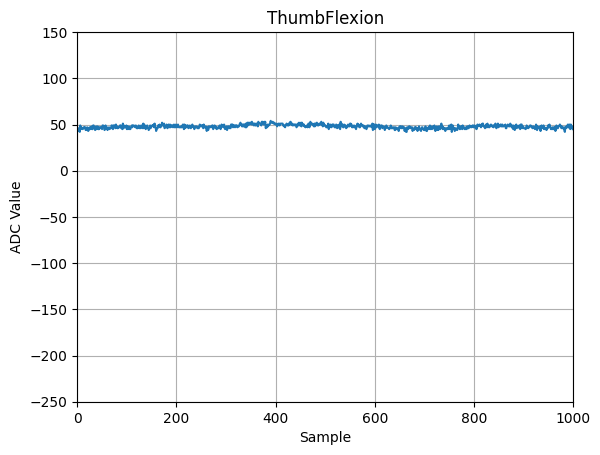

In [2]:
np.set_printoptions(suppress=True) # No scientific notation

# Raw analog input pin to read from file
pin = 1
file = "/sys/bus/iio/devices/iio:device0/in_voltage{}_raw".format(pin)
fd = open(file, "r")

########## CHANGE DEPENDING ON: FINGER, MOVEMENT, AMOUNT, SAMPLE NO ########## 
label = "Thumb" # "Thumb" or "Index" or "Middle" or "Ring" or "Pinky"
movement = "Flexion" # "Extension" or "Flexion"
sampleCount = 1000 # Amount of samples needed
sample = 1 # Increment manually, i.e., set to 1 first, then 2, 3 ...
############################################################################# 

sampleStart = sampleCount # For printouts
period = 0.001 # Sample period
data = [] # List of samples
t = time.time() # For controlling sample rate
startLoopTime = time.time() # For verification of sample rate accuracy

while True:
    t += period
    fd.seek(0) # Reset file pinter to begining of file
    value = float(fd.read().strip()) - 3412.0 # Read sensor value as float
    data.append(value) # Append sensor value to list
    time.sleep(max(0,t-time.time())) # Adjust sleep to get better time precision
    sampleCount -= 1
    if (sampleCount == 0): break # Change value to sample more

fd.close()

#Some information how it went
print("\nSampled " + str(sampleStart) + " samples in " + str(time.time() - startLoopTime) + " s")
print("Sample rate: " + str(1000 / (time.time() - startLoopTime) ).split('.')[0])

#Saving the data as a JSON file
jsonFileName = str(sample) + label + movement
jsonStructure = {'label': label, 'data': data}
with open("samples/" + jsonFileName + ".json", 'w') as f:
    json.dump(jsonStructure, f, indent = 4)

#Plotting the data
plt.plot(data)
plt.xlabel('Sample')
plt.ylabel('ADC Value')
plt.title(label + movement)
plt.xlim(0, 1000)
plt.ylim(-250, 150) #SHOULD be enough to contain min/max ADC values from our experiments, COULD be adjusted
plt.grid(True)